In [8]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss
from sklearn.metrics import roc_curve

import proplot as pplt

from roc_curve.bootstrap_samples import _bootstrap_samples
from roc_curve.plotting_proplot import ROC_Curve_proplot

base_dir = '/xfsdata/wpotosna'

In [2]:
lm_baseline_results = pd.read_csv(base_dir+'/disease_variant_prediction_language_model/LM_Baseline_results/LM_Baseline_test_results.csv')
eve_results = pd.read_csv(base_dir+'/disease_variant_prediction_language_model/EVE_results/EVE_test_results.csv')
lm_gnn_results = pd.read_csv(base_dir+'/disease_variant_prediction_language_model/LM_GNN_results/LM_GNN_test_results.csv')

/zfsauton2/home/wpotosna/.conda/envs/pgm_env/lib/python3.10/site-packages/proplot/axes/cartesian.py:725: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  getattr(self, 'set_' + x + 'lim')(lim)


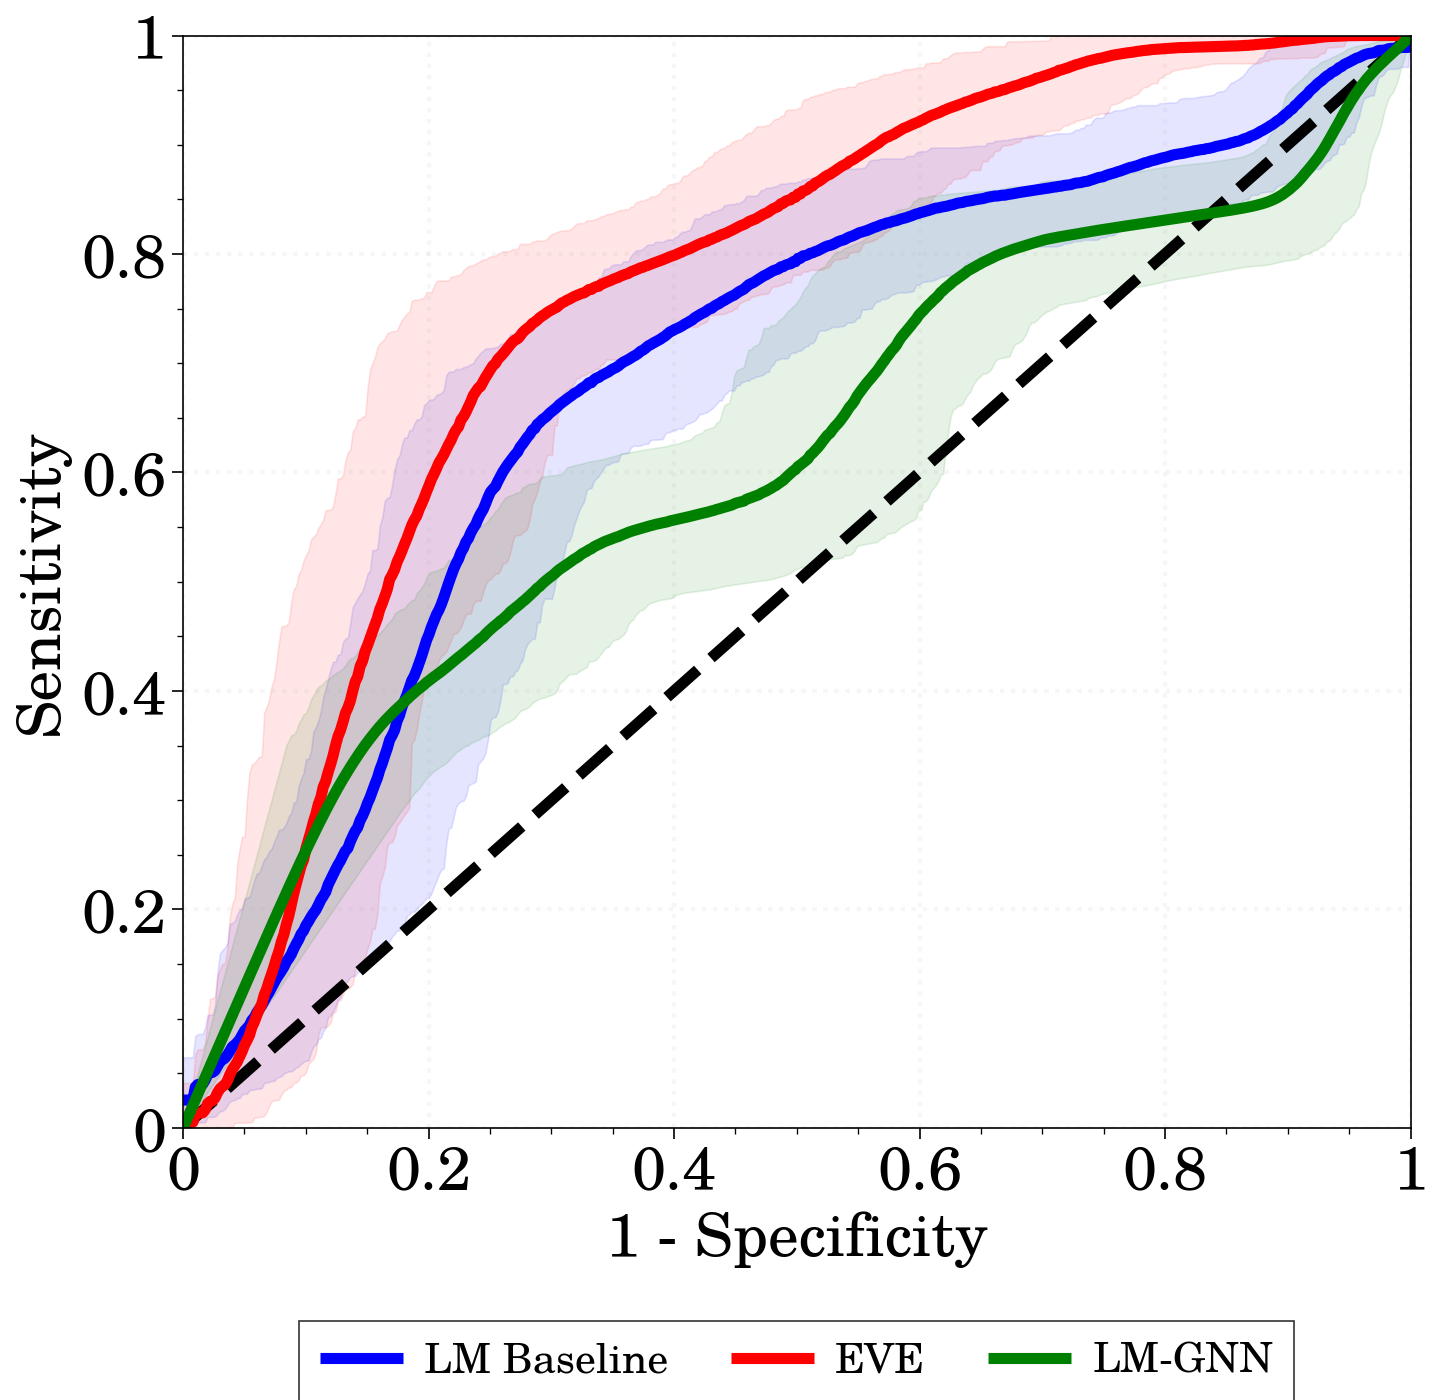

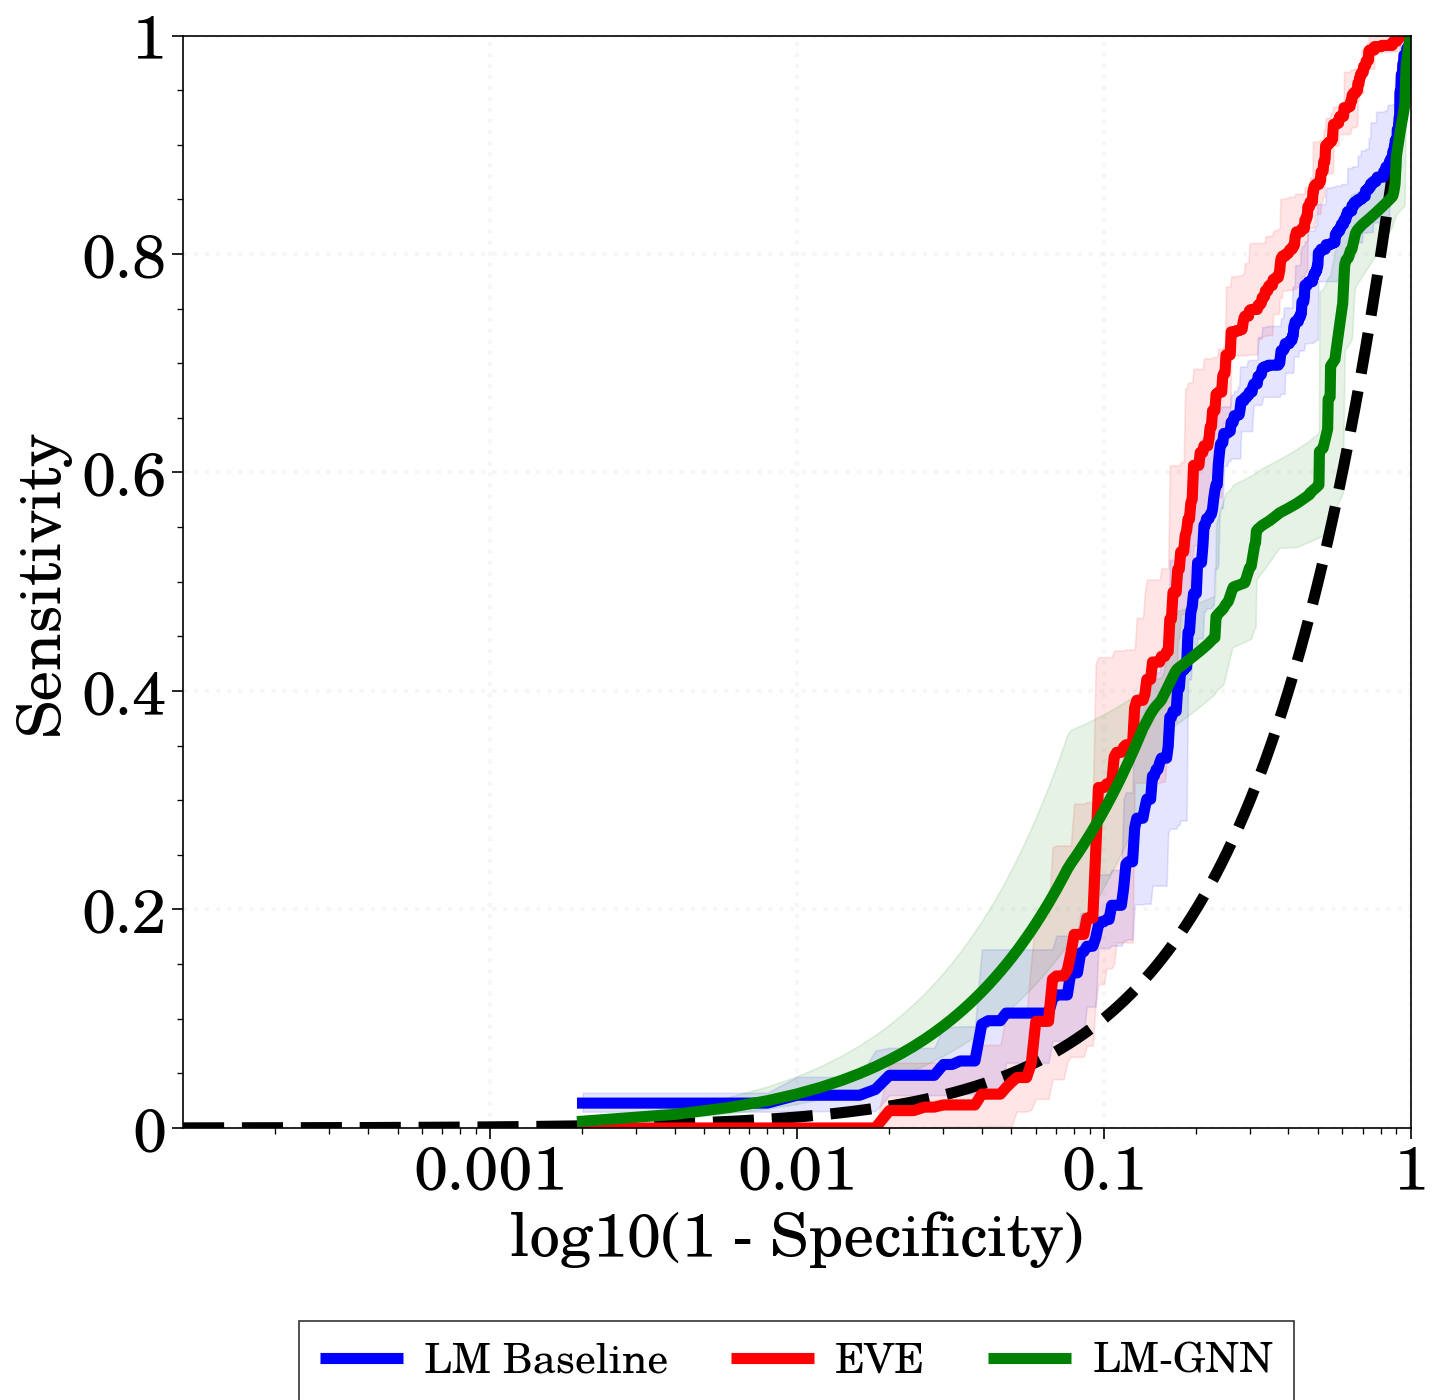

In [16]:

truth = [lm_baseline_results.ClinVar_labels, 
         eve_results.ClinVar_labels,
         lm_gnn_results.ClinVar_labels]

preds = [lm_baseline_results.EVE_scores, 
         eve_results.EVE_scores,
         lm_gnn_results.EVE_scores]

folds = [None, None, None]
labels = ['LM Baseline',
          'EVE',
          'LM-GNN']

colors = ['blue', 'red', 'green']

plt = ROC_Curve_proplot(axis_label_size='22', axis_tick_size='22', legend_text_size='15')

plt.plot(true_labels=truth, predictions=preds, folds=folds, xrange=(0,1), yrange=(0,1), direction='TPRvsFPR', 
         x_scale='linear', line_width=4, line_dash='solid', line_color=colors, legend_label=labels, 
         legend_location='lower center', ci_method='bootstrap', alpha=0.05, bootstrap_iters=500, random_seed=0,
         save_dir='./roc_curve.png'
        )

plt.plot(true_labels=truth, predictions=preds, folds=folds, xrange=(0,1), yrange=(0,1), direction='TPRvsFPR', 
         x_scale='log', line_width=4, line_dash='solid', line_color=colors, legend_label=labels, 
         legend_location='lower center', ci_method='bootstrap', alpha=0.05, bootstrap_iters=5, random_seed=0,
         save_dir='./log_roc_curve.png'
        )

In [3]:
from roc_curve.bootstrap_samples import *

In [21]:
def compute_metrics(bs_truth, bs_preds, folds):
    auc_vals = []
    ll_vals = []
    bs_vals = []
    tpr_1vals = []
    tpr_5vals = []
    
    for fold in set(folds.values.flatten()):
        auc_vals.append(roc_auc_score(bs_truth[folds.values==fold], 
                                      bs_preds[folds.values==fold]))
        ll_vals.append(log_loss(bs_truth[folds.values==fold], 
                                bs_preds[folds.values==fold]))
        bs_vals.append(brier_score_loss(bs_truth[folds.values==fold], 
                                        bs_preds[folds.values==fold]))
        tpr_1vals.append(get_tpr_at_fpr(bs_truth[folds.values==fold], 
                                       bs_preds[folds.values==fold], 
                                       select_fpr=0.01))
        tpr_5vals.append(get_tpr_at_fpr(bs_truth[folds.values==fold], 
                                       bs_preds[folds.values==fold], 
                                       select_fpr=0.05))
    
    metrics = {'ROC-AUC': str(np.round(np.mean(auc_vals), 3)) + 
               ' ('+str(np.round(np.mean(auc_vals)-1.96*np.std(auc_vals), 3))+
               ', '+str(np.round(np.mean(auc_vals)+1.96*np.std(auc_vals), 3))+')',
               
               'Sensitivity at 1% 1-Specificity': str(np.round(np.mean(tpr_1vals), 3)) + 
               ' ('+str(np.round(np.mean(tpr_1vals)-1.96*np.std(tpr_1vals), 3))+
               ', '+str(np.round(np.mean(tpr_1vals)+1.96*np.std(tpr_1vals), 3))+')',
               
               'Sensitivity at 5% 1-Specificity': str(np.round(np.mean(tpr_5vals), 3)) + 
               ' ('+str(np.round(np.mean(tpr_5vals)-1.96*np.std(tpr_5vals), 3))+
               ', '+str(np.round(np.mean(tpr_5vals)+1.96*np.std(tpr_5vals), 3))+')',
              
              'Logistic Loss': str(np.round(np.mean(ll_vals), 3)) + 
               ' ('+str(np.round(np.mean(ll_vals)-1.96*np.std(ll_vals), 3))+
               ', '+str(np.round(np.mean(ll_vals)+1.96*np.std(ll_vals), 3))+')',
    
              'Brier Score Loss': str(np.round(np.mean(bs_vals), 3)) + 
               ' ('+str(np.round(np.mean(bs_vals)-1.96*np.std(bs_vals), 3))+
               ', '+str(np.round(np.mean(bs_vals)+1.96*np.std(bs_vals), 3))+')'}
    
    return metrics

def get_tpr_at_fpr(true_labels, predictions, select_fpr, pos_label=None):
    """ Get TPR value at a defined FPR value.
    Parameters
    -----------
    true_labels : array
        Sample binary outcome labels.
        If labels are not either {-1, 1} or {0, 1}, then pos_label should be explicitly given.
    predictions : array
        Classifier scores
    select_fpr : float
        fpr value at which to identify the tpr value
    pos_label : int or str, default=None
        The label of the positive class.
        When pos_label=None, if y_true is in {-1, 1} or {0, 1}, pos_label is set to 1.
    Returns
    -----------
    float : tpr value
    """
    
    fpr, tpr, thres = roc_curve(true_labels, predictions, pos_label=pos_label, drop_intermediate=False)
    
    x_values = np.linspace(0, 1, 500)
    tpr_interp = np.interp(x_values, fpr, tpr, left=0, right=1)
    
    idx = np.where((abs(x_values-select_fpr)) == np.min(abs(x_values-select_fpr)))[0][0]
    identified_tpr = tpr_interp[idx]
    
    return identified_tpr

In [22]:
outcome_results = pd.DataFrame()
for dataset_name in ['LM_Baseline', 'EVE', 'LM_GNN']:
    if dataset_name == 'LM_Baseline': results = lm_baseline_results
    elif dataset_name == 'EVE': results = eve_results
    elif dataset_name == 'LM_GNN': results = lm_gnn_results

    truth, preds, folds = _bootstrap_samples(results.ClinVar_labels, 
                                             results.EVE_scores, 
                                             bootstrap_iters=500, 
                                             random_seed=0)
    metrics = compute_metrics(truth, preds, folds)
    metrics_df = pd.DataFrame(metrics, index=[dataset_name]).T
    metrics_df.index.name = 'Metric'
    outcome_results = pd.concat([outcome_results, metrics_df], axis=1)


In [23]:
outcome_results

,LM_Baseline,EVE,LM_GNN
Metric,,,
ROC-AUC,"0.684 (0.623, 0.745)","0.761 (0.7, 0.822)","0.609 (0.548, 0.67)"
Sensitivity at 1% 1-Specificity,"0.037 (-0.006, 0.08)","0.012 (-0.031, 0.056)","0.026 (0.012, 0.04)"
Sensitivity at 5% 1-Specificity,"0.089 (-0.005, 0.182)","0.076 (-0.058, 0.209)","0.129 (0.061, 0.197)"
Logistic Loss,"1.564 (1.253, 1.875)","1.031 (0.814, 1.248)","9.124 (8.139, 10.109)"
Brier Score Loss,"0.274 (0.23, 0.318)","0.228 (0.189, 0.266)","0.645 (0.591, 0.699)"


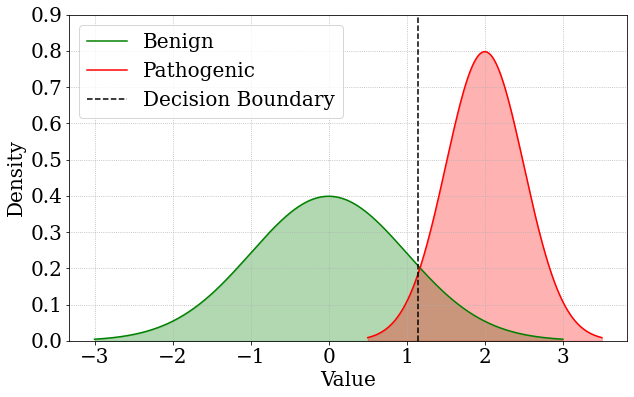

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the parameters for the two normal distributions
mu1 = 0
sigma1 = 1
mu2 = 2
sigma2 = 0.5


# Generate some random data from the two distributions
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 1000)
x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 1000)
y1 = 1/(sigma1*np.sqrt(2*np.pi))*np.exp(-(x1-mu1)**2/(2*sigma1**2))
y2 = 1/(sigma2*np.sqrt(2*np.pi))*np.exp(-(x2-mu2)**2/(2*sigma2**2))


fig=plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'serif'
# Plot the two normal distributions as smooth lines
plt.plot(x1, y1, label='Benign', color='green')
plt.plot(x2, y2, label='Pathogenic', color='red')
plt.fill_between(x1, y1, 0, alpha=0.3, color='green')
plt.fill_between(x2, y2, 0, alpha=0.3, color='red')

plt.plot(np.repeat(1.15, 5), np.linspace(0, 1, 5), '--', color='black', label='Decision Boundary')


# Add a legend and labels for the axes
plt.grid(True, ls=':')
plt.legend(fontsize=20)
plt.xlabel('Value', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.ylim([0, 0.9])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('./GMM.png')